In [86]:
#Setup
import numpy as np
from numpy.testing import assert_almost_equal
import scipy.integrate as integrate
from scipy.stats import norm
import matplotlib.pyplot as plt 
from matplotlib import rc
rc('text',usetex=True)
rc('lines', linewidth = 5)
plt.rcParams['figure.figsize'] = (20, 10)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
rc('font', **font)


## Part 0 - Setup

In [87]:
### Constants
sigma1 = 0.11
sigma2 = 0.13
T = 1.7
mu = 0.13
r = 0.01
S0 = 149
time_break = 0.3
K = 188
KH = S0
n_sims = 1_000 
n_steps = int(T * 365) #Assume time in years, this is daily time-steps

In [88]:
### Helper Functions

### Black-Scholes

def get_d1_and_d2(S, t, K, T, r, sigma):
    tau = T - t
    d1 = 1/(sigma * np.sqrt(tau)) * (np.log(S/K) + (r + sigma ** 2 / 2) * tau)    
    d2 = d1 - sigma * np.sqrt(tau)
    return d1, d2

def black_scholes_call_price(S, t, K, T, r,sigma):
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return S * norm.cdf(d1) - K * np.exp(-r * (T- t)) * norm.cdf(d2)

def black_scholes_put_price(S,t, K,T,r,sigma):
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return  K * np.exp(-r * (T - t)) * norm.cdf( -d2) - S * norm.cdf(-d1) 

def black_scholes_call_delta(S, t, K, T, r,sigma):
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return norm.cdf(d1)

def black_scholes_put_delta(S, t, K, T, r,sigma):
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return -1 * norm.cdf(-1 * d1)

def black_scholes_gamma(S, t, K, T, r,sigma):
    #same for a call and put
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return norm.pdf(d1)/(S * sigma * np.sqrt(T - t))

### Test helper functions. Numerical values evaluated on a calculator

assert_almost_equal(black_scholes_call_price(100,0,  100, 1, 0.01, 0.2), 8.43332, decimal = 5)
assert_almost_equal(black_scholes_call_price(100,0.99,  95, 1, 0.01, 0.2), 5.01264, decimal = 5)
assert_almost_equal(black_scholes_put_price(100,0, 100, 1, 0.01, 0.2), 7.43831, decimal = 5)
assert_almost_equal(black_scholes_put_price(100,0.99,  95, 1, 0.01, 0.2), 0.00314, decimal = 5)

assert_almost_equal(black_scholes_call_delta(100,0, 100, 1, 0.01, 0.2), 0.55962, decimal = 5)
assert_almost_equal(black_scholes_call_delta(100,0.99,  95, 1, 0.01, 0.2), 0.99506, decimal = 5)
assert_almost_equal(black_scholes_put_delta(100,0, 100, 1, 0.01, 0.2), -0.44038, decimal = 5)
assert_almost_equal(black_scholes_put_delta(100,0.99, 95, 1, 0.01, 0.2), -0.00494, decimal = 5)

assert_almost_equal(black_scholes_gamma(100,0, 100, 1, 0.01, 0.2), 0.01972, decimal = 5)
assert_almost_equal(black_scholes_gamma(100,0.99, 95, 1, 0.01, 0.2), 0.00716, decimal = 5)

In [89]:
class time_varying_vol:
    def __init__(self):
        pass
    
    def time_varying_vol(self, t):
        if t > time_break:
            return sigma1 + sigma2 * (t - time_break)/(T - time_break) #Note reference to global constant T, this is intentional 
        return sigma1

    def integrate_vol(self, start_time, end_time):
        squared_vol = lambda x: self.time_varying_vol(x) ** 2
        result = integrate.quad(squared_vol, start_time, end_time)
        return result[0]

###Testing time varying vol. Numerical values evaluated manually

Test_vol = time_varying_vol()
assert_almost_equal(np.array([Test_vol.time_varying_vol(0.2), Test_vol.time_varying_vol(0.4), Test_vol.time_varying_vol(0.5), Test_vol.time_varying_vol(T)]) ,
                    np.array([sigma1, 0.11928571428, 0.128571429, sigma1 + sigma2]))

assert_almost_equal(np.array([Test_vol.integrate_vol(start_time = 0, end_time = time_break), Test_vol.integrate_vol(0, 1), Test_vol.integrate_vol(start_time = 0, end_time = T)]),
                    np.array([time_break * sigma1 ** 2, 0.018090833333, 0.0484766666]))

In [90]:
def simulate_gbm(S0, mu, vol_model, n_steps, n_sims, simulation_end_time):
    rng = np.random.default_rng(seed = 42) #Seed for result consistency
    dt = simulation_end_time / n_steps
    times = np.linspace(0, simulation_end_time, n_steps + 1)
    epsilon = rng.normal(size = [n_sims, n_steps])
    
    paths = np.zeros([n_sims, n_steps + 1])
    paths[:, 0] = np.log(S0)

    for i in range(0, n_steps):
        #Euler-Maruyama Scheme, as in notes
        drift = (mu - 0.5 * vol_model.time_varying_vol(times[i]) ** 2) * dt
        stochastic = vol_model.time_varying_vol(times[i]) * np.sqrt(dt) * epsilon[:, i]
        paths[:, i + 1] = paths[:, i] + drift + stochastic
    
    paths = np.exp(paths)
    return times, paths

In [91]:
class Hedger:
    def __init__(self, S0, K, T, r, mu, n_sims, n_steps, vol_model, simulation_end_time = None, constant_vol_assumption = False, do_gamma_hedging = False):
        
        #Inputs
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.mu = mu
        self.vol_model = vol_model
        self.constant_vol_assumption = constant_vol_assumption
        self.n_sims = n_sims
        self.n_steps = n_steps
        self.do_gamma_hedging = do_gamma_hedging

        if self.do_gamma_hedging:
            self.constant_vol_assumption = True #override this - in this coursework if gamma hedging is happening i.e. Q3/Q4, we are assuming constant vol

        if simulation_end_time is not None:
            self.simulation_end_time = simulation_end_time
        else:
            self.simulation_end_time = T #Assume full period unless specified

        #Derived
        self.dt = self.simulation_end_time / self.n_steps
        full_period_vol = self.get_integrated_vol(0, self.T) 
        self.initial_price = black_scholes_call_price(self.S0, 0, self.K, self.T, self.r, full_period_vol)

        #Always need paths and payoffs, so do this on initialisation
        self.simulation_setup()
        self.get_final_call_prices()

    def get_integrated_vol(self, start_time, end_time):
        #calculates integrated vol over a remaining time period. Designed to return vol depending on the assumption of the investor
        if self.constant_vol_assumption:
            return self.vol_model.time_varying_vol(self.T)  
        else:
            return np.sqrt(1 / (end_time - start_time) * self.vol_model.integrate_vol(start_time = start_time, end_time = end_time))

    def simulation_setup(self):
        self.times, self.paths = simulate_gbm(self.S0, self.mu, self.vol_model, self.n_steps, self.n_sims, self.simulation_end_time)

    def get_final_call_prices(self):
        S_T = self.paths[:, -1]
        if self.simulation_end_time == self.T:
            #then call is maturing now so can use the payoff formula
            self.final_call_prices = np.maximum(S_T - self.K, 0)
        else:
            #call not yet matured, so needs to be priced using BS
            integrated_vol = self.get_integrated_vol(self.simulation_end_time, self.T)
            self.final_call_prices = black_scholes_call_price(S_T, self.simulation_end_time, self.K, self.T, self.r, integrated_vol)                  

    def simulate_delta_varying_vol(self):
        
        portfolio = np.zeros(self.paths.shape)
        portfolio[:, 0] = self.initial_price

        for i in range(0, len(self.times) - 1):
            t = self.times[i]
            
            S_at_t = self.paths[:, i] 
            S_at_t_plus_dt = self.paths[:, i+1]
            
            vol_t = self.get_integrated_vol(t, self.T)
            delta_t = black_scholes_call_delta(S_at_t, t, self.K, self.T, self.r, vol_t)

            if self.do_gamma_hedging:
                #we are holding an option. We derive the option holding based on gamma, then the stock holding based on delta
                t_plus_dt = self.times[i+1]

                #can use same vol everywhere because it is assumed constant
                hedge_option_at_t = black_scholes_put_price(S_at_t, t, KH, self.T,self.r, vol_t)
                hedge_option_at_t_plus_dt = black_scholes_put_price(S_at_t_plus_dt, t_plus_dt, KH, self.T,self.r, vol_t) 

                hedging_gamma = black_scholes_gamma(S_at_t, t, KH, self.T,self.r, vol_t)
                hedging_delta = black_scholes_put_delta(S_at_t, t, KH, self.T,self.r, vol_t)

                target_gamma = black_scholes_gamma(S_at_t, t, self.K, self.T,self.r, vol_t)

                option_holding = target_gamma / hedging_gamma
            else:
                #we aren't holding any option, so all the below need to be 0
                hedge_option_at_t = 0
                hedge_option_at_t_plus_dt = 0
                option_holding = 0
                hedging_delta = 0

            stock_holding = (delta_t - option_holding * hedging_delta)

            bank_at_t = portfolio[:, i] - stock_holding * S_at_t - option_holding * hedge_option_at_t
            bank_at_t_plus_dt = bank_at_t * np.exp(self.dt * self.r)
            
            new_stock_value = stock_holding * S_at_t_plus_dt
            new_option_value = option_holding * hedge_option_at_t_plus_dt

            portfolio[:, i + 1] = bank_at_t_plus_dt + new_stock_value + new_option_value
        
        final_portfolio = portfolio[:, -1]
        error = final_portfolio - self.final_call_prices
        return error, self.initial_price

## Q1 - Delta Hedging

Text(0, 0.5, 'Frequency')

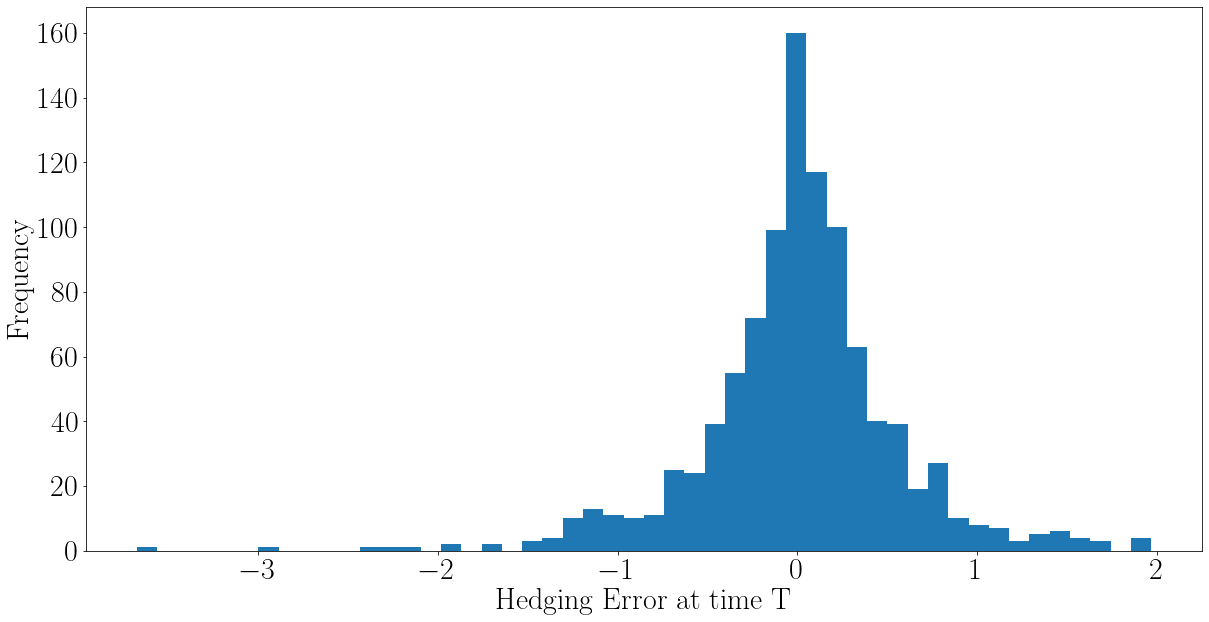

In [107]:
vol_model = time_varying_vol()

Q1 = Hedger(S0, K, T, r, mu, n_sims, n_steps, vol_model = vol_model)
error_Q1, price_Q1 = Q1.simulate_delta_varying_vol()
plt.hist(error_Q1, bins = 50)
plt.xlabel('Hedging Error at time T')
plt.ylabel('Frequency')



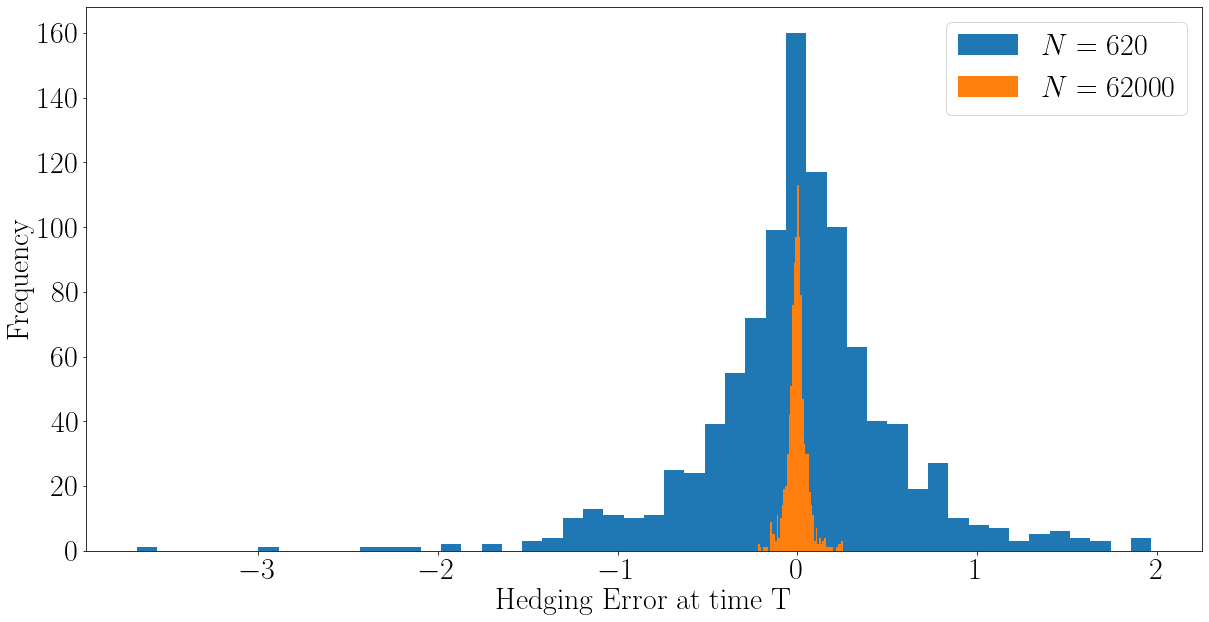

In [109]:

High_steps_Q1 = Hedger(S0, K, T, r, mu, n_sims, n_steps * 100, vol_model = vol_model)
error_Q1_high, price_Q1_high2 = High_steps_Q1.simulate_delta_varying_vol()

plt.hist(error_Q1, bins = 50, label = r'$N = 620$')
plt.hist(error_Q1_high, bins = 50, label = r'$N = 62000$')
plt.xlabel('Hedging Error at time T')
plt.ylabel('Frequency')
plt.legend()


In [94]:
print(price_Q1)

3.1573080857906497


In [95]:
assert_almost_equal(np.percentile(error_Q1, q = [2.5, 97.5]), np.array([-1.4437569,  1.4015494]))

AssertionError: 
Arrays are not almost equal to 7 decimals

Mismatched elements: 2 / 2 (100%)
Max absolute difference: 0.24383804
Max relative difference: 0.16889134
 x: array([-1.1999189,  1.168614 ])
 y: array([-1.4437569,  1.4015494])

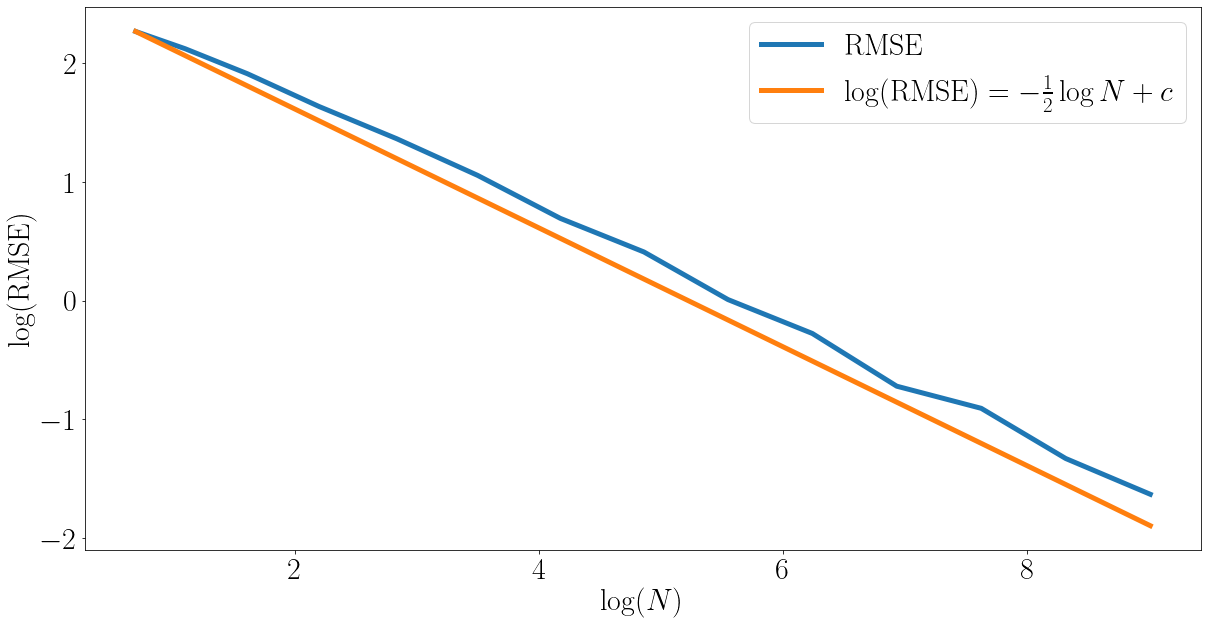

In [96]:
n_points = 14
n_steps_rme_testing = np.zeros(n_points)
rms_error = np.zeros(n_points)
for i in range(0, n_points):
    n_steps_rme_testing[i] = 2 ** i + 1
    dummy_hedger = Hedger(S0, K, T, r, mu, n_sims, int(n_steps_rme_testing[i]), vol_model = vol_model)
    error, price = dummy_hedger.simulate_delta_varying_vol()
    rms_error[i] = np.sqrt(np.mean(error ** 2))

plt.plot(np.log(n_steps_rme_testing), np.log(rms_error), label = 'RMSE')
plt.plot(np.log(n_steps_rme_testing), -0.5 * np.log(n_steps_rme_testing) + (np.log(rms_error[0]) + 0.5 * np.log(n_steps_rme_testing[0])), label = r'$\log($RMSE$) = -\frac{1}{2}\log{N} + c$')


plt.xlabel(r'$\log(N)$')
plt.ylabel(r'$\log($RMSE$)$')
plt.legend()


## Q2

In [97]:
Dummy = Hedger(S0, K, T, r, mu, n_sims, n_steps, vol_model = vol_model, simulation_end_time = T/2)

e, p = Dummy.simulate_delta_varying_vol()

Text(0, 0.5, 'Frequency')

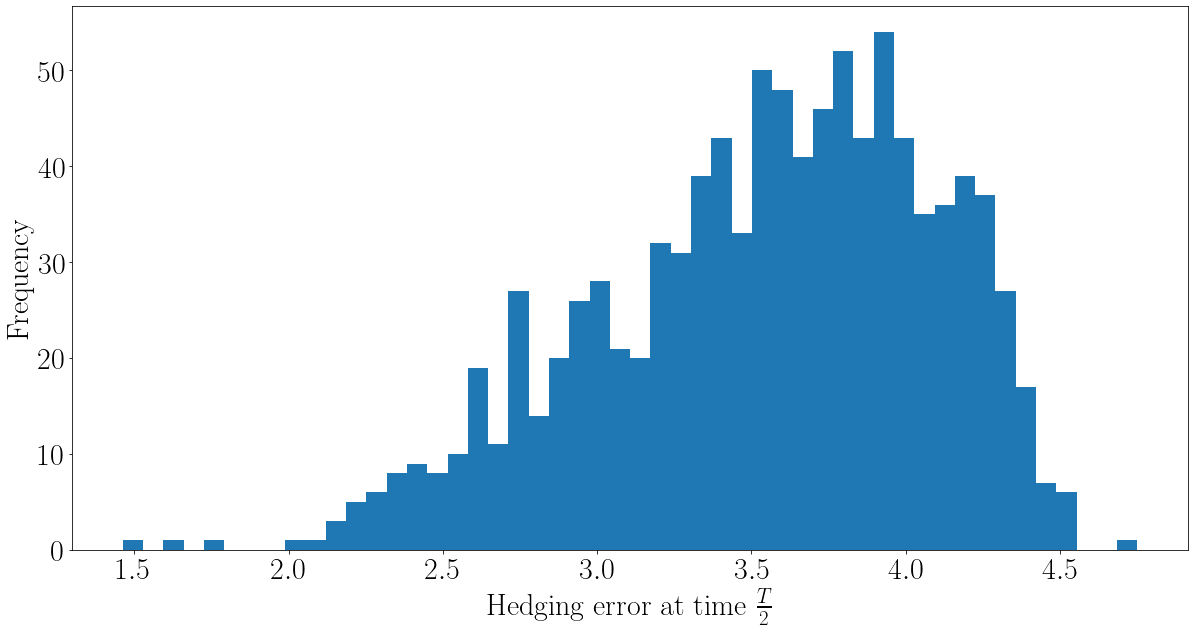

In [98]:
Q2 = Hedger(S0, K, T, r, mu, 1_000, 1_000, vol_model = vol_model, simulation_end_time = T/2, constant_vol_assumption = True)
error_Q2, price_Q2 = Q2.simulate_delta_varying_vol()


plt.hist(error_Q2, bins = 50)

plt.xlabel(r'Hedging error at time $\frac{T}{2}$')
plt.ylabel(r'Frequency')


In [99]:
assert_almost_equal(np.percentile(error_Q2, q = [2.5, 97.5]), np.array([2.3824194, 4.3781215]))

## Q3 

In [100]:
Q3_vol_model = time_varying_vol()

def flat_vol(t):
    return sigma1 + sigma2

Q3_vol_model.time_varying_vol = flat_vol

assert(Q3_vol_model.time_varying_vol(1) == sigma1 + sigma2)

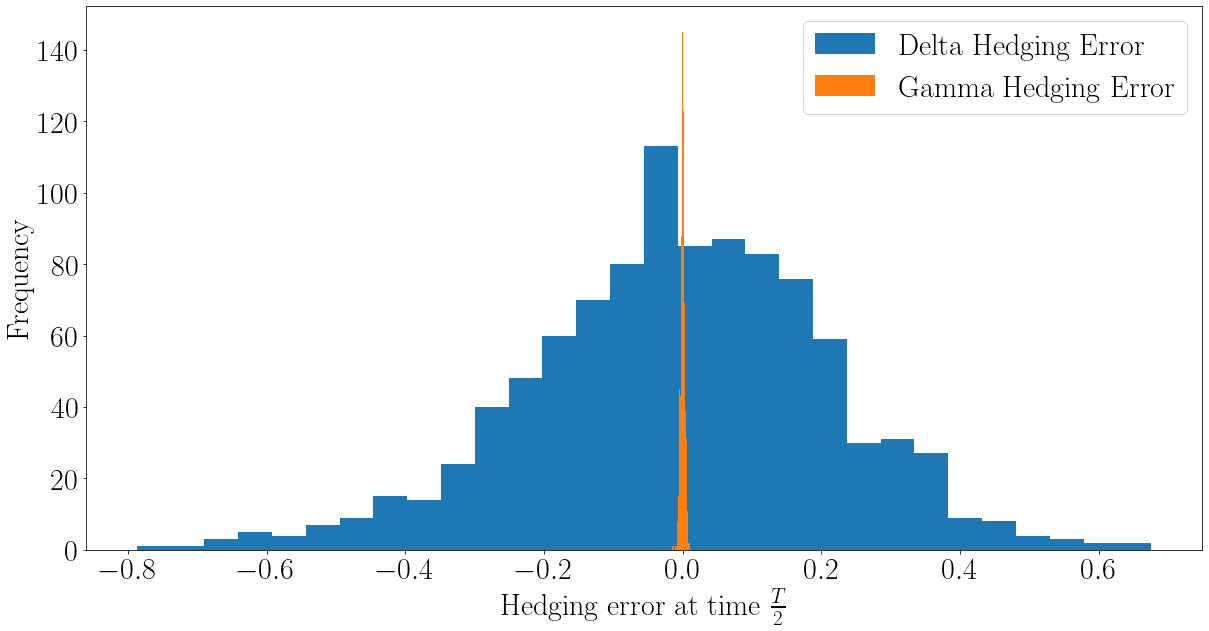

In [101]:
Q3_gamma = Hedger(S0, K, T, r, mu, n_sims, n_steps, vol_model = Q3_vol_model, simulation_end_time = T/2, constant_vol_assumption = True, do_gamma_hedging = True)
error_Q3_gamma, price_Q3_gamma = Q3_gamma.simulate_delta_varying_vol()

Q3_delta = Hedger(S0, K, T, r, mu, n_sims, n_steps, vol_model = Q3_vol_model, simulation_end_time = T/2, constant_vol_assumption = True, do_gamma_hedging = False)
error_Q3_delta, price_Q3_delta = Q3_delta.simulate_delta_varying_vol()
plt.hist(error_Q3_delta, bins = 30, label = 'Delta Hedging Error')
plt.hist(error_Q3_gamma, bins = 30, label = 'Gamma Hedging Error')

plt.xlabel(r'Hedging error at time $\frac{T}{2}$')
plt.ylabel(r'Frequency')
plt.legend()

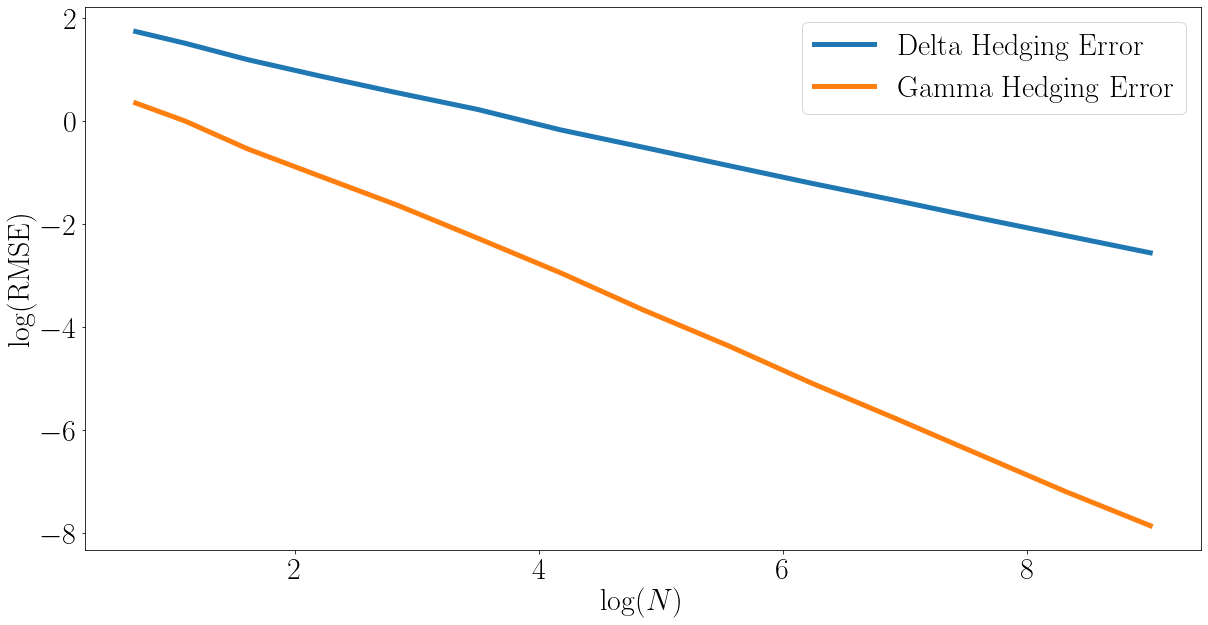

In [102]:
n_points = 14
n_steps_rme_testing = np.zeros(n_points)
rms_error_delta = np.zeros(n_points)
rms_error_gamma = np.zeros(n_points)

for i in range(0, n_points):
    n_steps_rme_testing[i] = 2 ** i + 1
    dummy_hedger_delta = Hedger(S0, K, T, r, mu, n_sims, int(n_steps_rme_testing[i]), vol_model = Q3_vol_model,  simulation_end_time = T/2, constant_vol_assumption = True, do_gamma_hedging = False)
    dummy_hedger_gamma = Hedger(S0, K, T, r, mu, n_sims, int(n_steps_rme_testing[i]), vol_model = Q3_vol_model,  simulation_end_time = T/2, constant_vol_assumption = True, do_gamma_hedging = True)
    delta_error, delta_price = dummy_hedger_delta.simulate_delta_varying_vol()
    rms_error_delta[i] = np.sqrt(np.mean(delta_error ** 2))

    gamma_error, gamma_price = dummy_hedger_gamma.simulate_delta_varying_vol()
    rms_error_gamma[i] = np.sqrt(np.mean(gamma_error ** 2))

plt.plot(np.log(n_steps_rme_testing), np.log(rms_error_delta), label = 'Delta Hedging Error')
plt.plot(np.log(n_steps_rme_testing), np.log(rms_error_gamma), label = 'Gamma Hedging Error')


plt.xlabel(r'$\log(N)$')
plt.ylabel(r'$\log($RMSE$)$')
plt.legend()


## Q4

(array([ 3.,  7., 35., 52., 67., 66., 80., 76., 70., 71., 73., 64., 59.,
        49., 38., 42., 33., 20., 31., 17., 14.,  6.,  4.,  6.,  3.,  6.,
         1.,  1.,  3.,  3.]),
 array([-2.56403046e-03, -2.20503963e-03, -1.84604879e-03, -1.48705796e-03,
        -1.12806712e-03, -7.69076289e-04, -4.10085454e-04, -5.10946190e-05,
         3.07896216e-04,  6.66887051e-04,  1.02587789e-03,  1.38486872e-03,
         1.74385956e-03,  2.10285039e-03,  2.46184123e-03,  2.82083206e-03,
         3.17982290e-03,  3.53881373e-03,  3.89780457e-03,  4.25679540e-03,
         4.61578624e-03,  4.97477707e-03,  5.33376791e-03,  5.69275874e-03,
         6.05174958e-03,  6.41074041e-03,  6.76973125e-03,  7.12872208e-03,
         7.48771292e-03,  7.84670375e-03,  8.20569459e-03]),
 <BarContainer object of 30 artists>)

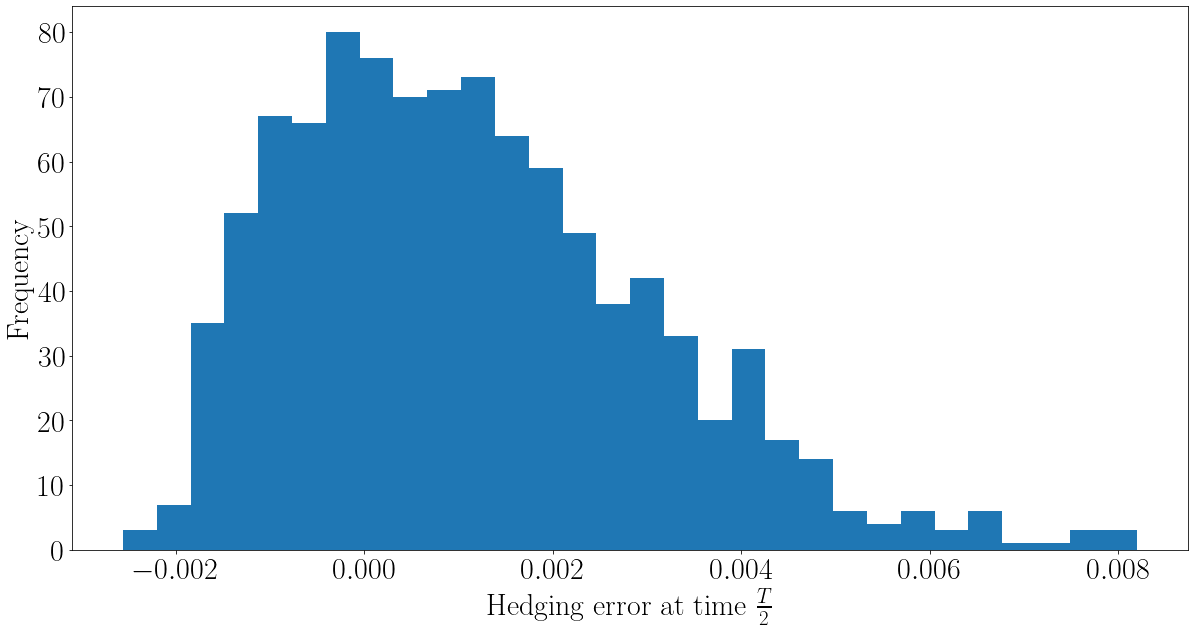

In [103]:
Q4_vol_model = time_varying_vol()
Q4 = Hedger(S0, K, T, r, mu, 1_000, 1_000, vol_model = Q4_vol_model, simulation_end_time = T/2, constant_vol_assumption = True, do_gamma_hedging = True)
error_Q4, price_Q4 = Q4.simulate_delta_varying_vol()


plt.xlabel(r'Hedging error at time $\frac{T}{2}$')
plt.ylabel(r'Frequency')


plt.hist(error_Q4, bins = 30)

In [104]:
assert_almost_equal(np.percentile(error_Q4, q = [2.5, 97.5]), [-0.0017121,  0.0053743 ])